
# Lab exercises 3

For this lab exercises, please submit 2 notebooks / python script and 2 reports, one for each part. The deadline is 22 december.

It is important the you read the documentation to understand how to use Pytorch functions, what kind of transformation they apply etc. You have to take time to read it carefully to understand what you are doing.

    https://pytorch.org/docs/stable/nn.html
    https://pytorch.org/docs/stable/torch.html


# 1. Part one: MNIST classification with Pytorch

The goal of the first part is to learn how to use Pytorch and to observe the impact of regularization during training. You should test different network architectures, e.g. with hidden layers of size 128-128, 128-64-32-16, 256-128-64-32-16, 512-256-128-64-32-16, 800-800, and different activation functions (tanh, relu, sigmoid).

Remember that Pytorch expects data in a different format than in the previous lab exercise: the first dimension is always the batch dimension.

In [0]:
import os
import torch
import dataset_loader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

--2019-12-13 20:57:55--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.99MB/s    in 3.1s    

2019-12-13 20:57:58 (4.99 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [4]:
image = torch.from_numpy(train_data[0][0])
print(image.shape) # flat image of dim (784,)

# reshape the tensor so it is represented as a batch containing a single image
# -1 means "all remaining elements", here it would be equivalent to image.reshape(1, 784)
image = image.reshape(1, -1)
print(image.shape) # flat image of dim (1, 784)

torch.Size([784])
torch.Size([1, 784])


In [0]:
def create_batch(data, index, batch_size):
  if index + batch_size > len(data[0]): batch_size = len(data[0]) - index - 1
  return (torch.cat(
      [
          # we reshape the image tensor so it has dimension (1, 784)
          torch.from_numpy(image).reshape(1, -1)
          for image in data[0][index:index + batch_size]
      ],
      # we want to concatenate on the batch dimension
      dim=0),

      torch.tensor(data[1][index:index + batch_size])
  )

## 1.2. Layer initialization

By default, Pytorch will apply Kaiming initialization to linear layers. However, I recommend you to always explicitly initialize you network by hand in the constructor.

## 1.3. Regularization

You can try two types of regularization (they can be combined together):

- weight decay: it is a parameter of the optimizer
- dropout: see slides

## 1.4. Gradient clipping

A commong trick for training neural networks is gradient clipping: if the norm of the gradient is too big, we rescale the gradient. This trick can be used to prevent exploding gradients and also to make "too big steps" in the wrong direction due the use of approximate gradient computation in SGD.


In [0]:
def get_activation(activations, index):
  if activations[index] == 'relu':
    return torch.relu
  elif activations[index] == 'leaky_relu':
    return torch.leaky_relu
  elif activations[index] == 'elu':
    return torch.elu
  elif activations[index] == 'tanh':
    return torch.tanh
  elif activations[index] == 'sigmoid':
    return torch.sigmoid
  else:
    raise Exception('unknown activation')

In [0]:
def get_initialization(activations, index):
  if activations[index] == 'relu':
    return torch.nn.init.kaiming_uniform_
  elif activations[index] == 'tanh':
    return torch.nn.init.xavier_uniform_
  else:
    return torch.nn.init.xavier_uniform_

In [0]:
class Mlp_classifier(torch.nn.Module):
  def __init__(self, input_dim, num_classes, num_hidden_layers, hidden_layers_dim, activations, dropouts):
    assert isinstance(hidden_layers_dim, list)
    assert isinstance(activations, list)
    assert len(hidden_layers_dim) == num_hidden_layers
    assert len(activations) == num_hidden_layers
    assert isinstance(dropouts, list)
    assert len(dropouts) == num_hidden_layers + 1 # dropout is also for the input layer

    self.activations = activations
    self.dropouts = [torch.nn.Dropout(p=d) for d in dropouts]

    super().__init__()

    self.z_projs = torch.nn.ModuleList()

    i = 0
    previous_layer_dim = input_dim
    for hdim in hidden_layers_dim:
      linear = torch.nn.Linear(previous_layer_dim, hdim)

      initialization = get_initialization(self.activations, i)
      initialization(linear.weight.data)
      torch.nn.init.zeros_(linear.bias.data)
      self.z_projs.append(linear)
      
      previous_layer_dim = hdim
      i += 1

    self.output_proj = torch.nn.Linear(previous_layer_dim, num_classes)

  def forward(self, batch):
    z = batch
    i = 0
    for nn in self.z_projs:
      z = self.dropouts[i](z)
      activation = get_activation(self.activations, i)
      z = activation(nn(z))
      i += 1
    out = self.output_proj(z)
    return out

In [0]:
nn = Mlp_classifier(
    784,      # input dimension
    10,       # number of classes
    2,        # number of hidden layers
    [800,800],    # dimension size(s) of the hidden layer(s)
    ['relu','relu'], # activation function(s) per layer
    [0,0.,0.]   # dropout probabilitie(s) per layer
)

In [0]:
optimizer = torch.optim.SGD(
    nn.parameters(),
    lr=0.01,
    weight_decay=0.01
)

In [0]:
loss_builder = torch.nn.NLLLoss(reduction='mean')
m = torch.nn.LogSoftmax(dim=1)

In [121]:
batch_size = 64
n_epochs = 10
dev_loss_list = []
dev_acc_list = []

for epoch in range(n_epochs):
  nn.train()
  for i in range(0,len(train_data[0]),batch_size):
    batch = create_batch(train_data, i, batch_size)
    x = batch[0]
    gold = batch[1]
    y = nn(x)
    loss = loss_builder(m(y),gold)

    nn.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(nn.parameters(), 5.)  # clip gradient if its norm exceed 5
    optimizer.step()

  nn.eval()
  dev_acc = 0
  for i in range(0,len(dev_data[0]),1):
    batch = create_batch(dev_data, i, 1)
    x = batch[0]
    gold = batch[1]
    y = nn(x)

    if np.argmax(m(y).detach().numpy()) == gold: dev_acc += 1

  dev_acc /= dev_data[0].shape[0]

  dev_loss_list.append(loss.item())
  dev_acc_list.append(dev_acc)

  print("Epoch: {:d}/{:d}".format(epoch+1,n_epochs))
  print ("Dev Avg Loss:", loss.item(), "\t\tDev Accurancy:", dev_acc)
  print()

Epoch: 1/10
Dev Avg Loss: 0.6103399991989136 		Dev Accurancy: 0.8946

Epoch: 2/10
Dev Avg Loss: 0.4742746353149414 		Dev Accurancy: 0.9078

Epoch: 3/10
Dev Avg Loss: 0.4062660336494446 		Dev Accurancy: 0.9155

Epoch: 4/10
Dev Avg Loss: 0.36761727929115295 		Dev Accurancy: 0.9207

Epoch: 5/10
Dev Avg Loss: 0.3434004485607147 		Dev Accurancy: 0.9258

Epoch: 6/10
Dev Avg Loss: 0.32613882422447205 		Dev Accurancy: 0.9297

Epoch: 7/10
Dev Avg Loss: 0.31310489773750305 		Dev Accurancy: 0.9316

Epoch: 8/10
Dev Avg Loss: 0.30324414372444153 		Dev Accurancy: 0.9334

Epoch: 9/10
Dev Avg Loss: 0.29524680972099304 		Dev Accurancy: 0.9348

Epoch: 10/10
Dev Avg Loss: 0.28885066509246826 		Dev Accurancy: 0.9371



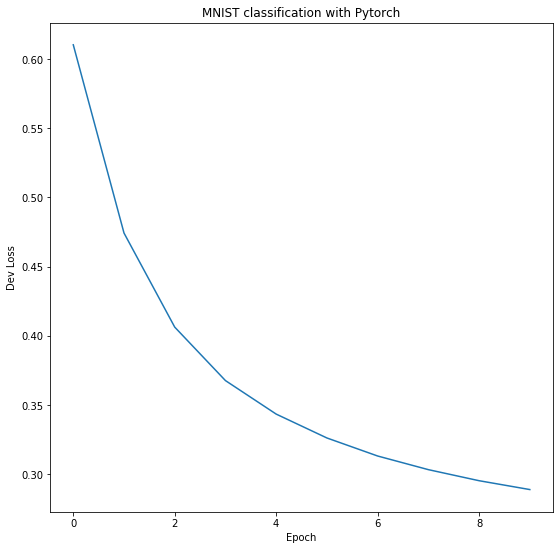

In [122]:
plt.figure(figsize=(9,9))
plt.plot([e for e in range(n_epochs)],dev_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Dev Loss')
plt.title('MNIST classification with Pytorch')
plt.savefig('part1.1_loss_800_800_relu_0.0_0.01.png')

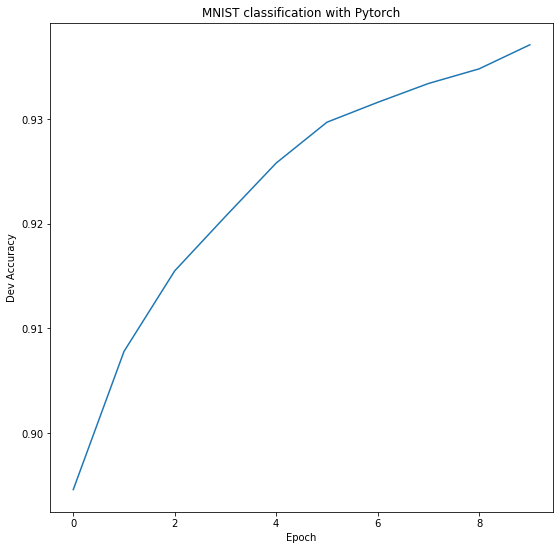

In [123]:
plt.figure(figsize=(9,9))
plt.plot([e for e in range(n_epochs)],dev_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Dev Accuracy')
plt.title('MNIST classification with Pytorch')
plt.savefig('part1.1_acc_800_800_relu_0.0_0.01.png')

## 1.4. Bonus: Convolutional Neural Network

You can try to rely on a CNN instead of a MLP to classify MNIST images (you can still have a single layer MLP on top of convolutions, after pooling!). Note that this will requires you to reshape the input images!

https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d

In [0]:
def create_batch_conv(data, index, batch_size):
  if index + batch_size > len(data[0]): batch_size = len(data[0]) - index - 1
  return (torch.cat(
      [
          # we reshape the image tensor so it has dimension (1, 784)
          torch.from_numpy(image).reshape(1, 1, 28, 28)
          for image in data[0][index:index + batch_size]
      ],
      # we want to concatenate on the batch dimension
      dim=0),

      torch.tensor(data[1][index:index + batch_size])
  )

In [0]:
class CNN_classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_model = torch.nn.Sequential(
        torch.nn.Conv2d(1,32,kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,stride=2)
    )

    self.linear = torch.nn.Linear(32*13*13,10)

  def forward(self, batch):
    z = batch
    z = self.conv_model(z)
    z = z.view(-1, 32*13*13)
    return self.linear(z)

In [0]:
cnn = CNN_classifier()

In [0]:
optimizer = torch.optim.SGD(
    cnn.parameters(),
    lr=0.01
)

In [0]:
loss_builder = torch.nn.NLLLoss(reduction='mean')
m = torch.nn.LogSoftmax(dim=1)

In [115]:
batch_size = 64
n_epochs = 10
dev_loss_list = []
dev_acc_list = []

for epoch in range(n_epochs):
  cnn.train()
  for i in range(0,len(train_data[0]),batch_size):
    batch = create_batch_conv(train_data, i, batch_size)
    x = batch[0]
    gold = batch[1]
    y = cnn(x)
    loss = loss_builder(m(y),gold)

    cnn.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(cnn.parameters(), 5.)  # clip gradient if its norm exceed 5
    optimizer.step()

  cnn.eval()
  dev_acc = 0
  for i in range(0,len(dev_data[0]),1):
    batch = create_batch_conv(dev_data, i, 1)
    x = batch[0]
    gold = batch[1]
    y = cnn(x)

    if np.argmax(m(y).detach().numpy()) == gold: dev_acc += 1

  dev_acc /= dev_data[0].shape[0]
  
  dev_loss_list.append(loss.item())
  dev_acc_list.append(dev_acc)

  print("Epoch: {:d}/{:d}".format(epoch+1,n_epochs))
  print ("Dev Avg Loss:", loss.item(), "\t\tDev Accurancy:", dev_acc)
  print()

Epoch: 1/10
Dev Avg Loss: 0.5621078014373779 		Dev Accurancy: 0.8973

Epoch: 2/10
Dev Avg Loss: 0.459921658039093 		Dev Accurancy: 0.9073

Epoch: 3/10
Dev Avg Loss: 0.40337181091308594 		Dev Accurancy: 0.9113

Epoch: 4/10
Dev Avg Loss: 0.3612370789051056 		Dev Accurancy: 0.9157

Epoch: 5/10
Dev Avg Loss: 0.3228093087673187 		Dev Accurancy: 0.9204

Epoch: 6/10
Dev Avg Loss: 0.2860851585865021 		Dev Accurancy: 0.9255

Epoch: 7/10
Dev Avg Loss: 0.25150713324546814 		Dev Accurancy: 0.9291

Epoch: 8/10
Dev Avg Loss: 0.21920906007289886 		Dev Accurancy: 0.9341

Epoch: 9/10
Dev Avg Loss: 0.1897365301847458 		Dev Accurancy: 0.938

Epoch: 10/10
Dev Avg Loss: 0.1632859706878662 		Dev Accurancy: 0.942



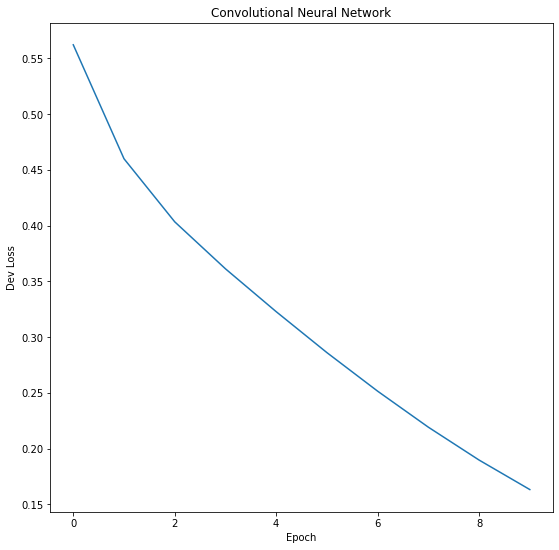

In [116]:
plt.figure(figsize=(9,9))
plt.plot([e for e in range(n_epochs)],dev_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Dev Loss')
plt.title('Convolutional Neural Network')
plt.savefig('part1.2_loss.png')

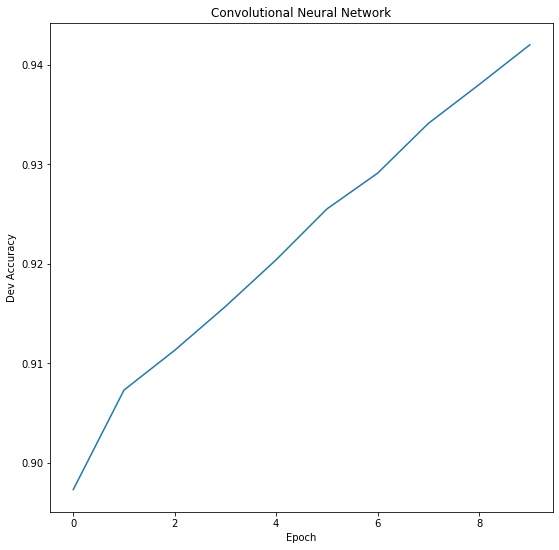

In [117]:
plt.figure(figsize=(9,9))
plt.plot([e for e in range(n_epochs)],dev_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Dev Accuracy')
plt.title('Convolutional Neural Network')
plt.savefig('part1.2_acc.png')